MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [3]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [6]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [8]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [10]:
# Replace missing codes in Wellbeing column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [11]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [13]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In [14]:
category_order = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very high': 4
}
cleaned = cleaned.copy()
cleaned['Wellbeing_category_num'] = cleaned['Wellbeing_category'].map(category_order)

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [16]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [17]:
# Define mapping
aage_to_avg = {
    2.0: 17,  # 16-17
    3.0: 19,  # 18-19
    4.0: 22,    # 20-24
    5.0: 27,    # 25-29
    6.0: 32,    # 30-34
    7.0: 37,    # 35-39
    8.0: 42,    # 40-44
    9.0: 47,    # 45-49
    10.0: 52,   # 50-54
    11.0: 57,   # 55-59
    12.0: 62,   # 60-64
    13.0: 82    # 65-99
}

# Apply mapping 
cleaned['AGE'] = cleaned['AAGE'].map(aage_to_avg)

In [18]:
# Map GOR9d to numeric codes
region_map = {
    'E12000001': 1,  # North East
    'E12000002': 2,  # North West
    'E12000003': 3,  # Yorkshire and The Humber
    'E12000004': 4,  # East Midlands
    'E12000005': 5,  # West Midlands
    'E12000006': 6,  # East of England
    'E12000007': 7,  # London
    'E12000008': 8,  # South East
    'E12000009': 9,  # South West
    'L99999999': 10, # Channel Islands (pseudo)
    'M99999999': 11, # Isle of Man (pseudo)
    'N99999999': 12, # Northern Ireland
    'S99999999': 13, # Scotland (pseudo)
    'W99999999': 14  # Wales (pseudo)
}

# Apply the mapping to create a new column
cleaned['GOR9d_num'] = cleaned['GOR9d'].map(region_map)

In [19]:
import numpy as np

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype
for col in health_cols:
    cleaned[col] = cleaned[col].astype('Int64')

# Step 3: Replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].replace(-8, np.nan)

# Step 4: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 5: Only create columns if they don’t already exist
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'
    if col_name not in cleaned.columns:
        cleaned[col_name] = cleaned[health_cols].apply(
            lambda row: int(code in row.dropna().values), axis=1
        )

print("HEALTH columns created.")

HEALTH columns created.


In [20]:
cleaned.to_csv("cleaned.csv", index=False)

In [21]:
cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Data exploration**


In [23]:
# Dictionary
feature_labels = {
    # SEX
    'SEX_1': 'Male',
    'SEX_2': 'Female',

    # ETHUKEUL (Ethnicity)
    'ETHUKEUL_1.0': 'White',
    'ETHUKEUL_2.0': 'Mixed/Multiple ethnic groups',
    'ETHUKEUL_3.0': 'Indian',
    'ETHUKEUL_4.0': 'Pakistani',
    'ETHUKEUL_5.0': 'Bangladeshi',
    'ETHUKEUL_6.0': 'Chinese',
    'ETHUKEUL_7.0': 'Any other Asian background',
    'ETHUKEUL_8.0': 'Black/African/Caribbean/Black British',
    'ETHUKEUL_9.0': 'Other ethnic group',

    # MARDY6 (Marital status)
    'MARDY6_1': 'Married/Cohabiting/Civil Partner',
    'MARDY6_2': 'Non-married',

    # ILODEFR (Economic activity)
    'ILODEFR_1': 'In employment',
    'ILODEFR_2': 'ILO unemployed',
    'ILODEFR_3': 'Inactive',

    # TEN1 (Accommodation details)
    'TEN1_1.0': 'Owned outright',
    'TEN1_2.0': 'Being bought with mortgage or loan',
    'TEN1_3.0': 'Part rent, part mortgage',
    'TEN1_4.0': 'Rented',
    'TEN1_5.0': 'Rent free or squatted',
    'TEN1_6.0': 'Squatting',

    # XDISDDA20 (Unadjusted DDA disabled)
    'XDISDDA20_-9': 'Does not apply',
    'XDISDDA20_1': 'Current disability only',
    'XDISDDA20_2': 'Current and past disabled',
    'XDISDDA20_3': 'Past disability only',
    'XDISDDA20_4': 'Not DDA disabled',

    # LEVQUL22 (RQF Level of highest qualification)
    'LEVQUL22_-9': 'Does not apply',
    'LEVQUL22_1': 'RQF Level 8 (Doctorate)',
    'LEVQUL22_2': 'RQF Level 7 (Master’s)',
    'LEVQUL22_3': 'RQF Level 6 (Bachelor’s)',
    'LEVQUL22_4': 'RQF Level 5 (HND/Foundation Degree)',
    'LEVQUL22_5': 'RQF Level 4 (CertHE)',
    'LEVQUL22_6': 'RQF Level 3 (A-Levels)',
    'LEVQUL22_7': 'RQF Level 2 (GCSE A*-C)',
    'LEVQUL22_8': 'RQF Level 1 (GCSE D-G)',
    'LEVQUL22_9': 'RQF Entry Level',
    'LEVQUL22_10': 'Other Qualifications',
    'LEVQUL22_11': 'No Qualifications',
    'LEVQUL22_12': 'Don’t Know (Qualification)',

    # INDE07M (Industry sector in main job)
    'INDE07M_-9.0': 'Does not apply',
    'INDE07M_1.0': 'Agriculture, forestry and fishing',
    'INDE07M_2.0': 'Energy and water',
    'INDE07M_3.0': 'Manufacturing',
    'INDE07M_4.0': 'Construction',
    'INDE07M_5.0': 'Distribution, hotels and restaurants',
    'INDE07M_6.0': 'Transport and communication',
    'INDE07M_7.0': 'Banking and finance',
    'INDE07M_8.0': 'Public admin, education and health',
    'INDE07M_9.0': 'Other services',

    # RELIG11 (Religion)
    'RELIG11_1.0': 'No Religion',
    'RELIG11_2.0': 'Christian',
    'RELIG11_3.0': 'Buddhist',
    'RELIG11_4.0': 'Hindu',
    'RELIG11_5.0': 'Jewish',
    'RELIG11_6.0': 'Muslim',
    'RELIG11_7.0': 'Sikh',
    'RELIG11_8.0': 'Other Religion',

    # GOR9d (Region)
    '1': 'North East',
    '2': 'North West',
    '3': 'Yorkshire and The Humber',
    '4': 'East Midlands',
    '5': 'West Midlands',
    '6': 'East of England',
    '7': 'London',
    '8': 'South East',
    '9': 'South West',
    '10': '(pseudo) Channel Islands',
    '11': '(pseudo) Isle of Man',
    '12': 'Northern Ireland',
    '13': '(pseudo) Scotland',
    '14': '(pseudo) Wales',

    # HEALTH binary indicators
    'HEALTH_Diabetes': 'Diabetes',
    'HEALTH_MentalAnxiety': 'Mental Anxiety',
    'HEALTH_ArmsOrHands': 'Arms/Hands Disability',
    'HEALTH_LegsOrFeet': 'Legs/Feet Disability',
    'HEALTH_BackOrNeck': 'Back/Neck Disability',
    'HEALTH_MentalIllness': 'Mentai Illness',
    'HEALTH_Autism': 'Autism',
    'HEALTH_ProgressiveIllness': 'ProgressiveIllness',
    'HEALTH_HeartOrCirculation': 'HeartOrCirculation',
    'NATIDB11': 'British Identity',
}

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Define relevant columns
columns = {
    'AGE': 'AGE',  
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'XDISDDA20',
    'QUALIFICATION': 'LEVQUL22',
    'Job_Sector': 'INDE07M',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d_num',
    'DIABETES': 'HEALTH_Diabetes',
    'MentalAnxiety': 'HEALTH_MentalAnxiety',
    'ArmsDisability': 'HEALTH_ArmsOrHands',
    'LegsDisability': 'HEALTH_LegsOrFeet',
    'BackDisability': 'HEALTH_BackOrNeck',
    'MentalIllness': 'HEALTH_MentalIllness',
    'Autism': 'HEALTH_Autism',
    'ProgressiveIllness': 'HEALTH_ProgressiveIllness',
    'HeartOrCirculation': 'HEALTH_HeartOrCirculation'
}

# Updated groups
nominal_cols = ['LEVQUL22', 'ILODEFR', 'MARDY6', 'SEX',
                'ETHUKEUL', 'TEN1', 'XDISDDA20', 'INDE07M', 'RELIG11', 'GOR9d_num']
binary_cols = ['NATIDB11', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety',
               'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 'HEALTH_BackOrNeck', 'HEALTH_MentalIllness',
              'HEALTH_Autism', 'HEALTH_ProgressiveIllness', 'HEALTH_HeartOrCirculation']
continuous_cols = ['AGE'] 
# Step 2: Extract relevant data
relevant_cols = list(columns.values()) + ['Wellbeing_category_num']
model_df = cleaned[relevant_cols].copy()

# Step 3: Only drop NaNs (do NOT replace -9s; assume AGE has NaN where AAGE was -8/-9)
model_df = model_df.dropna()

# Step 4: Separate X and y
X = model_df[[v for v in columns.values()]].copy()
y = model_df['Wellbeing_category_num'].copy()

# Step 5: Ensure correct types
for col in binary_cols:
    X[col] = X[col].astype(int)
for col in nominal_cols:
    X[col] = X[col].astype('category')
for col in continuous_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')  # ensure AGE is numeric

# Step 6: One-hot encode all nominal variables (exclude AGE)
X_nominal = pd.get_dummies(X[nominal_cols], drop_first=False)
X_final = pd.concat([X[continuous_cols], X[binary_cols], X_nominal], axis=1)

# Step 7: First split — 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, random_state=42, stratify=y
)

# Step 8: Second split — 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Step 9: Check final shapes
print(f" Train: {X_train.shape}")
print(f" Validation: {X_val.shape}")
print(f" Test: {X_test.shape}")

 Train: (113869, 78)
 Validation: (24401, 78)
 Test: (24401, 78)



Overall Wellbeing_category_num distribution (full dataset):
Wellbeing_category_num
1.0     5774
2.0    18735
3.0    74053
4.0    64109
Name: count, dtype: int64

Wellbeing_category_num distribution in y_train (before SMOTE):
Wellbeing_category_num
1.0     4042
2.0    13114
3.0    51837
4.0    44876
Name: count, dtype: int64


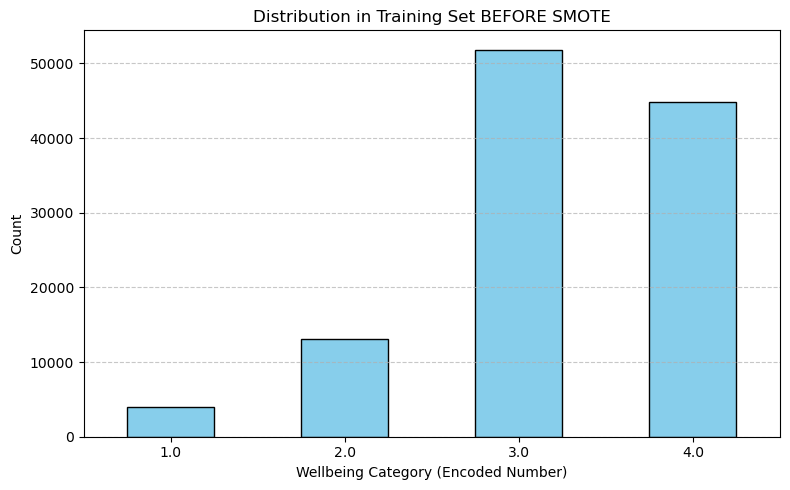


Wellbeing_category_num distribution in y_train (AFTER SMOTE):
Wellbeing_category_num
1.0    51837
2.0    51837
3.0    51837
4.0    51837
Name: count, dtype: int64


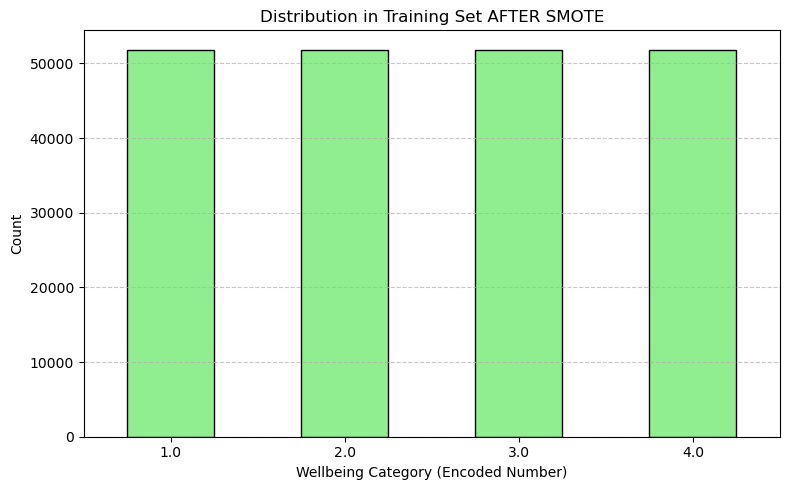

In [25]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


# SScale AGE (continuous column) ONLY on training and validation/test separately
scaler = StandardScaler()
X_train_scaled_cont = scaler.fit_transform(X_train[continuous_cols])
X_val_scaled_cont = scaler.transform(X_val[continuous_cols])
X_test_scaled_cont = scaler.transform(X_test[continuous_cols])

# Combine scaled continuous + unscaled binary + one-hot nominal
X_train_scaled = np.hstack([X_train_scaled_cont, X_train[binary_cols].values, X_train[X_nominal.columns].values])
X_val_scaled = np.hstack([X_val_scaled_cont, X_val[binary_cols].values, X_val[X_nominal.columns].values])
X_test_scaled = np.hstack([X_test_scaled_cont, X_test[binary_cols].values, X_test[X_nominal.columns].values])

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# --------- BEFORE SMOTE ---------
print("\nOverall Wellbeing_category_num distribution (full dataset):")
print(y.value_counts(dropna=False).sort_index())

print("\nWellbeing_category_num distribution in y_train (before SMOTE):")
print(y_train.value_counts(dropna=False).sort_index())

# Plot BEFORE SMOTE
plt.figure(figsize=(8, 5))
y_train.value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('Wellbeing Category (Encoded Number)')
plt.ylabel('Count')
plt.title('Distribution in Training Set BEFORE SMOTE')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --------- AFTER SMOTE ---------
print("\nWellbeing_category_num distribution in y_train (AFTER SMOTE):")
print(pd.Series(y_train_resampled).value_counts().sort_index())

# Plot
plt.figure(figsize=(8, 5))
pd.Series(y_train_resampled).value_counts().sort_index().plot(
    kind='bar',
    color='lightgreen',
    edgecolor='black'
)
plt.xlabel('Wellbeing Category (Encoded Number)')
plt.ylabel('Count')
plt.title('Distribution in Training Set AFTER SMOTE')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

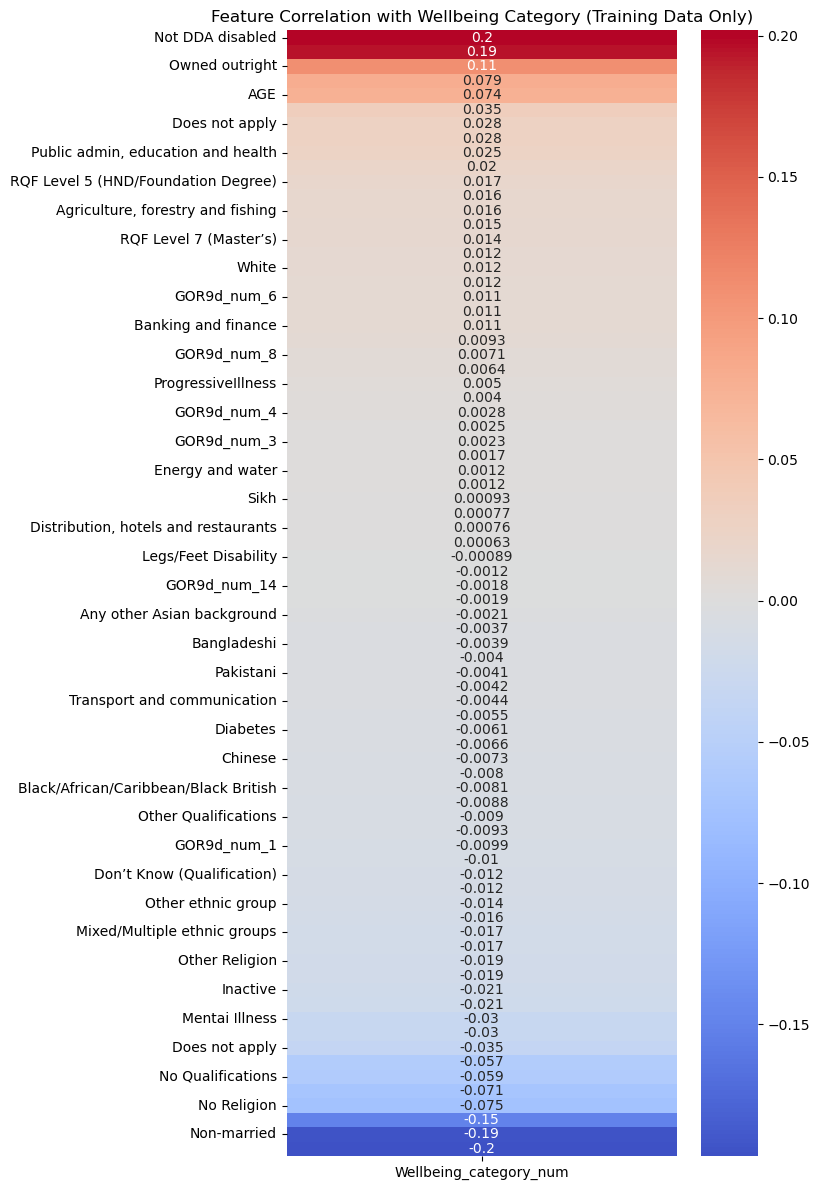

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy of the original training features
X_corr = X_train.copy()

# Add the original (pre-SMOTE) target variable to the DataFrame
X_corr['Wellbeing_category_num'] = y_train

# Compute correlation matrix (only numeric features)
corr_matrix = X_corr.corr(numeric_only=True)

# Get correlation of each feature with the target
target_corr = corr_matrix[['Wellbeing_category_num']].drop('Wellbeing_category_num')

# Apply readable labels to features (fallback to original if not found)
target_corr.index = target_corr.index.map(lambda x: feature_labels.get(x, x))

# Plot heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(
    target_corr.sort_values(by='Wellbeing_category_num', ascending=False),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Feature Correlation with Wellbeing Category (Training Data Only)")
plt.tight_layout()
plt.show()

## **Logistic regression**


=== Logistic Regression (L2) ===
Classification Report:
              precision    recall  f1-score   support

         1.0       0.10      0.59      0.17       866
         2.0       0.16      0.17      0.16      2811
         3.0       0.54      0.30      0.39     11108
         4.0       0.50      0.52      0.51      9616

    accuracy                           0.38     24401
   macro avg       0.32      0.39      0.31     24401
weighted avg       0.46      0.38      0.40     24401

Confusion Matrix:
[[ 507  120   89  150]
 [1078  481  560  692]
 [2119 1528 3379 4082]
 [1423  960 2269 4964]]


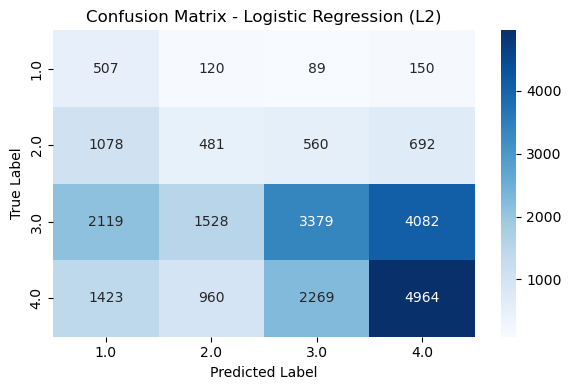


=== Lasso Logistic Regression (L1) ===
Classification Report:
              precision    recall  f1-score   support

         1.0       0.09      0.61      0.16       866
         2.0       0.16      0.14      0.15      2811
         3.0       0.54      0.31      0.39     11108
         4.0       0.50      0.52      0.51      9616

    accuracy                           0.38     24401
   macro avg       0.32      0.39      0.30     24401
weighted avg       0.46      0.38      0.40     24401

Confusion Matrix:
[[ 528   93   89  156]
 [1153  382  563  713]
 [2346 1206 3407 4149]
 [1594  733 2271 5018]]


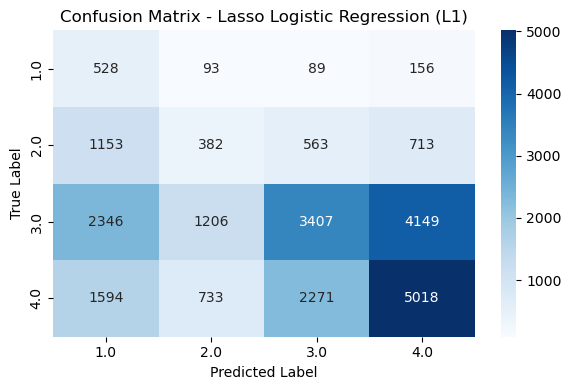


=== Ridge Classifier ===
Classification Report:
              precision    recall  f1-score   support

         1.0       0.09      0.64      0.16       866
         2.0       0.16      0.09      0.11      2811
         3.0       0.54      0.30      0.39     11108
         4.0       0.50      0.54      0.52      9616

    accuracy                           0.38     24401
   macro avg       0.32      0.39      0.29     24401
weighted avg       0.46      0.38      0.40     24401

Confusion Matrix:
[[ 558   60   82  166]
 [1256  247  551  757]
 [2615  807 3366 4320]
 [1753  479 2202 5182]]


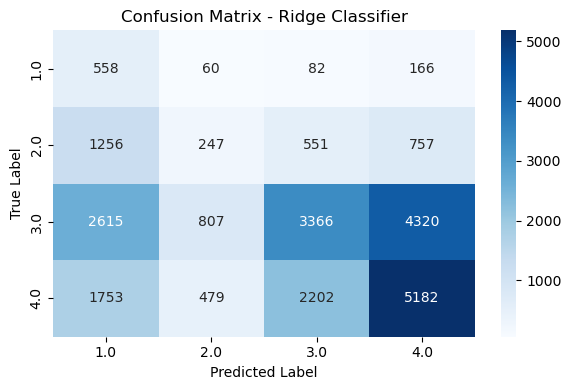


=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

         1.0       0.10      0.12      0.11       866
         2.0       0.18      0.17      0.18      2811
         3.0       0.49      0.47      0.48     11108
         4.0       0.46      0.50      0.48      9616

    accuracy                           0.43     24401
   macro avg       0.31      0.31      0.31     24401
weighted avg       0.43      0.43      0.43     24401

Confusion Matrix:
[[ 100  204  337  225]
 [ 215  477 1246  873]
 [ 415 1119 5175 4399]
 [ 291  819 3731 4775]]


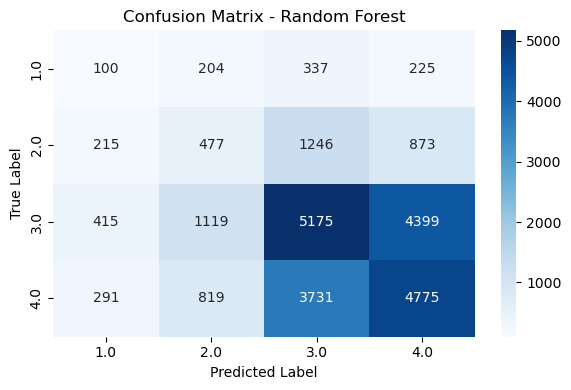


=== Gradient Boosting ===
Classification Report:
              precision    recall  f1-score   support

         1.0       0.14      0.39      0.21       866
         2.0       0.19      0.13      0.16      2811
         3.0       0.53      0.47      0.50     11108
         4.0       0.50      0.53      0.52      9616

    accuracy                           0.45     24401
   macro avg       0.34      0.38      0.35     24401
weighted avg       0.46      0.45      0.45     24401

Confusion Matrix:
[[ 335  128  211  192]
 [ 593  372 1073  773]
 [ 869  863 5205 4171]
 [ 517  554 3410 5135]]


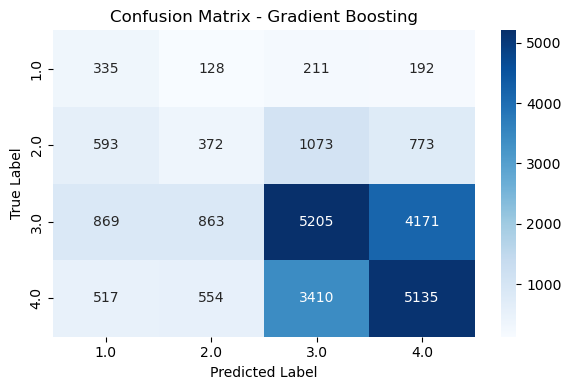

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Define all classifiers
models = {
    "Logistic Regression (L2)": LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42),
    "Lasso Logistic Regression (L1)": LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42),
    "Ridge Classifier": RidgeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # Train on SMOTE-resampled training data
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Predict on original scaled test set
    y_pred = pipeline.predict(X_test_scaled)
    
    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Visualize confusion matrix
    class_labels = sorted(y_test.unique()) if hasattr(y_test, 'unique') else sorted(set(y_test))
    plot_confusion_matrix(cm, class_labels, name)